# InSituPy demonstration - Analyze data

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import scanpy as sc
from insitupy import InSituData, CACHE

## Load Xenium data into `InSituData` object

Now the Xenium data can be parsed by providing the data path to the `InSituPy` project folder.

In [3]:
# prepare paths
data_dir = Path(CACHE / "out/demo_insitupy_project") # directory of xenium data
xd = InSituData.read(data_dir)

In [4]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\.cache\InSituPy\out\demo_insitupy_project
Metadata file:	.ispy

No modalities loaded.

In [5]:
# read all data modalities at once
xd.load_all()

# alternatively, it is also possible to read each modality separately
# xd.load_cells()
# xd.load_images()
# xd.load_transcripts()
# xd.read_annotations()

Note: That the `annotations` and `regions` modalities are not found here is expected. Annotations are added in a later step.

In [6]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\.cache\InSituPy\out\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 167780 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
       boundaries
           BoundariesData object with 2 entries:
               cells
               nuclei
    ➤ transcripts
       DataFrame with shape Delayed('int-3072996b-0d60-46a6-9d94-22170c37464a') x 8

## Explore data in interactive `napari` viewer

Example image of the viewer:

<left><img src="./demo_screenshots/whole_napari_viewer.png" width="800"/></left>

For detailed documentation on the functionalities of `napari` see the official documentation [here](https://napari.org/stable/index.html).

In [7]:
xd.show()

### Explore gene expression using `napari` viewer

Use the `"Add cells"` widget to explore the single-cell transcriptomic data.

<left><img src="./demo_screenshots/add_cells.jpg" width="350"/></left>

Genes can be selected from the dropdown window by scrolling or by clicking into the window and typing the name of the item:

<left><img src="./demo_screenshots/select_gene.jpg" width="350"/></left>

After selection of an item it can be added using the `"Add"` button. The data is added as point layer to the napari viewer.

## Perform preprocessing steps

`InSituPy` also includes basic preprocessing functions to normalize the transcriptomic data and perform dimensionality reduction. For normalization, the ``ScanPy`` function `sc.pp.normalize_total()` is used. Data transformation can be either done using logarithmic transformation or square root transformation as suggested [here](https://stlearn.readthedocs.io/en/latest/tutorials/Xenium_PSTS.html).

For a general introduction into preprocessing steps in single-cell transcriptomics analysis, the [single-cell best practices book](https://www.sc-best-practices.org/preamble.html) is a great ressource.


### Calculate QC metrices

Now we use the Scanpy function `calculate_qc_metrics` to calculate the QC metrices, which we will afterwards use to filter the data and remove low quality cells.

In [7]:
sc.pp.calculate_qc_metrics(
    xd.cells.matrix, percent_top=None, log1p=False, inplace=True
)

### Filtering

In our experience the QC metrices can vary a lot between different samples. Therefore, it is important to explore every dataset separately before making decisions on filtering thresholds. Also, it can be beneficial to try to split the dataset before filtering into different cell lineages (e.g. epithelial vs. non-epithelial) and use different thresholds per lineage, since even within cell types there can be large variations in the QC metrices. This can be especially the case for technologies like Xenium where a rather small gene panel is used and the transcript counts depend a lot on whether the panel contains marker genes of a certain cell type or not.

In [9]:
from insitupy.utils.preprocessing import plot_qc_metrics

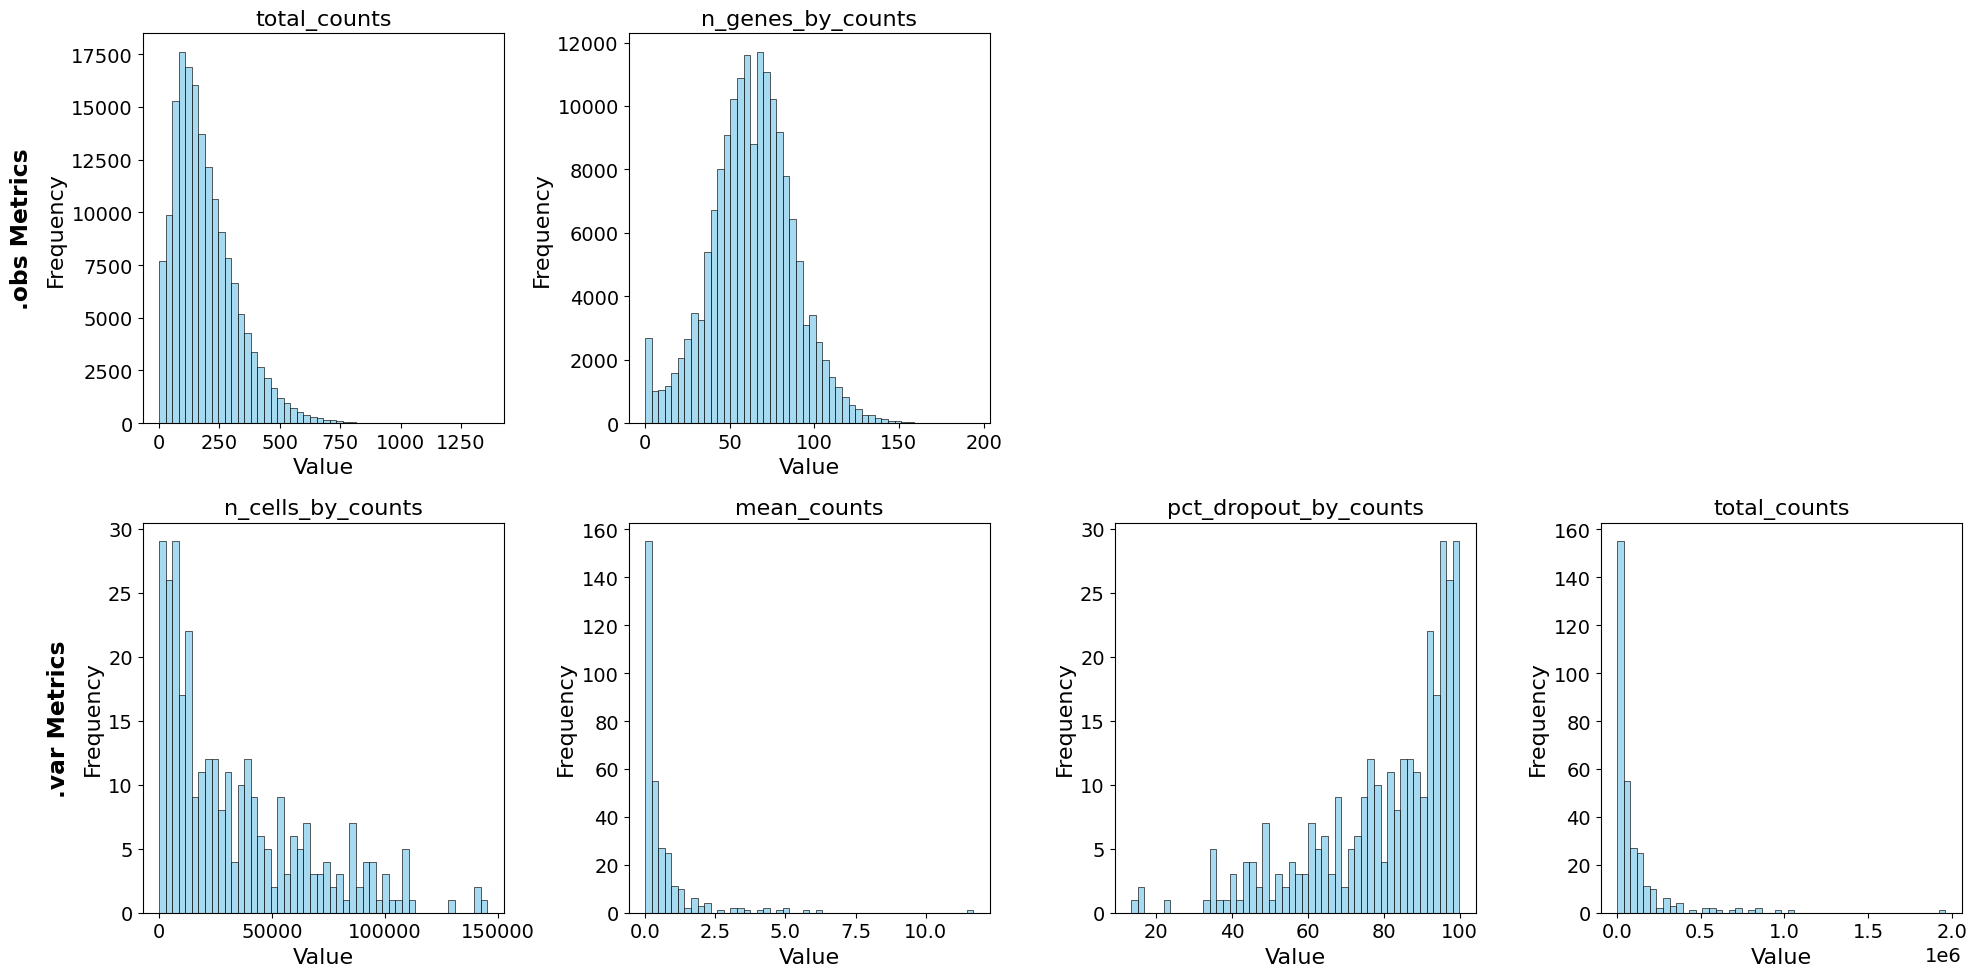

In [10]:
plot_qc_metrics(xd.cells.matrix)

For filtering there are different options, but in this case we chose to filter on two parameters: `n_genes_by_counts` and `n_cell_by_counts`. The first parameter filters out cells (`.obs`) in which only a very small number of genes were found and the second parameter filters out genes (`.var`) which were only found in a very small number of cells. As threshold we chose cells with less than 25 genes and genes which were found in less than 1% of the cells.

In [20]:
sc.pp.filter_cells(xd.cells.matrix, min_genes=25)

In [13]:
xd.cells.matrix

AnnData object with n_obs × n_vars = 157600 × 313
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'spatial'

In [24]:
cell_number = xd.cells.matrix.shape[0]
cell_threshold = cell_number * 0.01
print(f"Threshold for cells per gene: {cell_threshold}")

Threshold for cells per gene: 1575.89


In [25]:
sc.pp.filter_genes(xd.cells.matrix, min_cells=cell_threshold)

In [26]:
xd.cells.matrix

AnnData object with n_obs × n_vars = 157589 × 297
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    obsm: 'spatial'

After the filter the QC metrices look as follows:

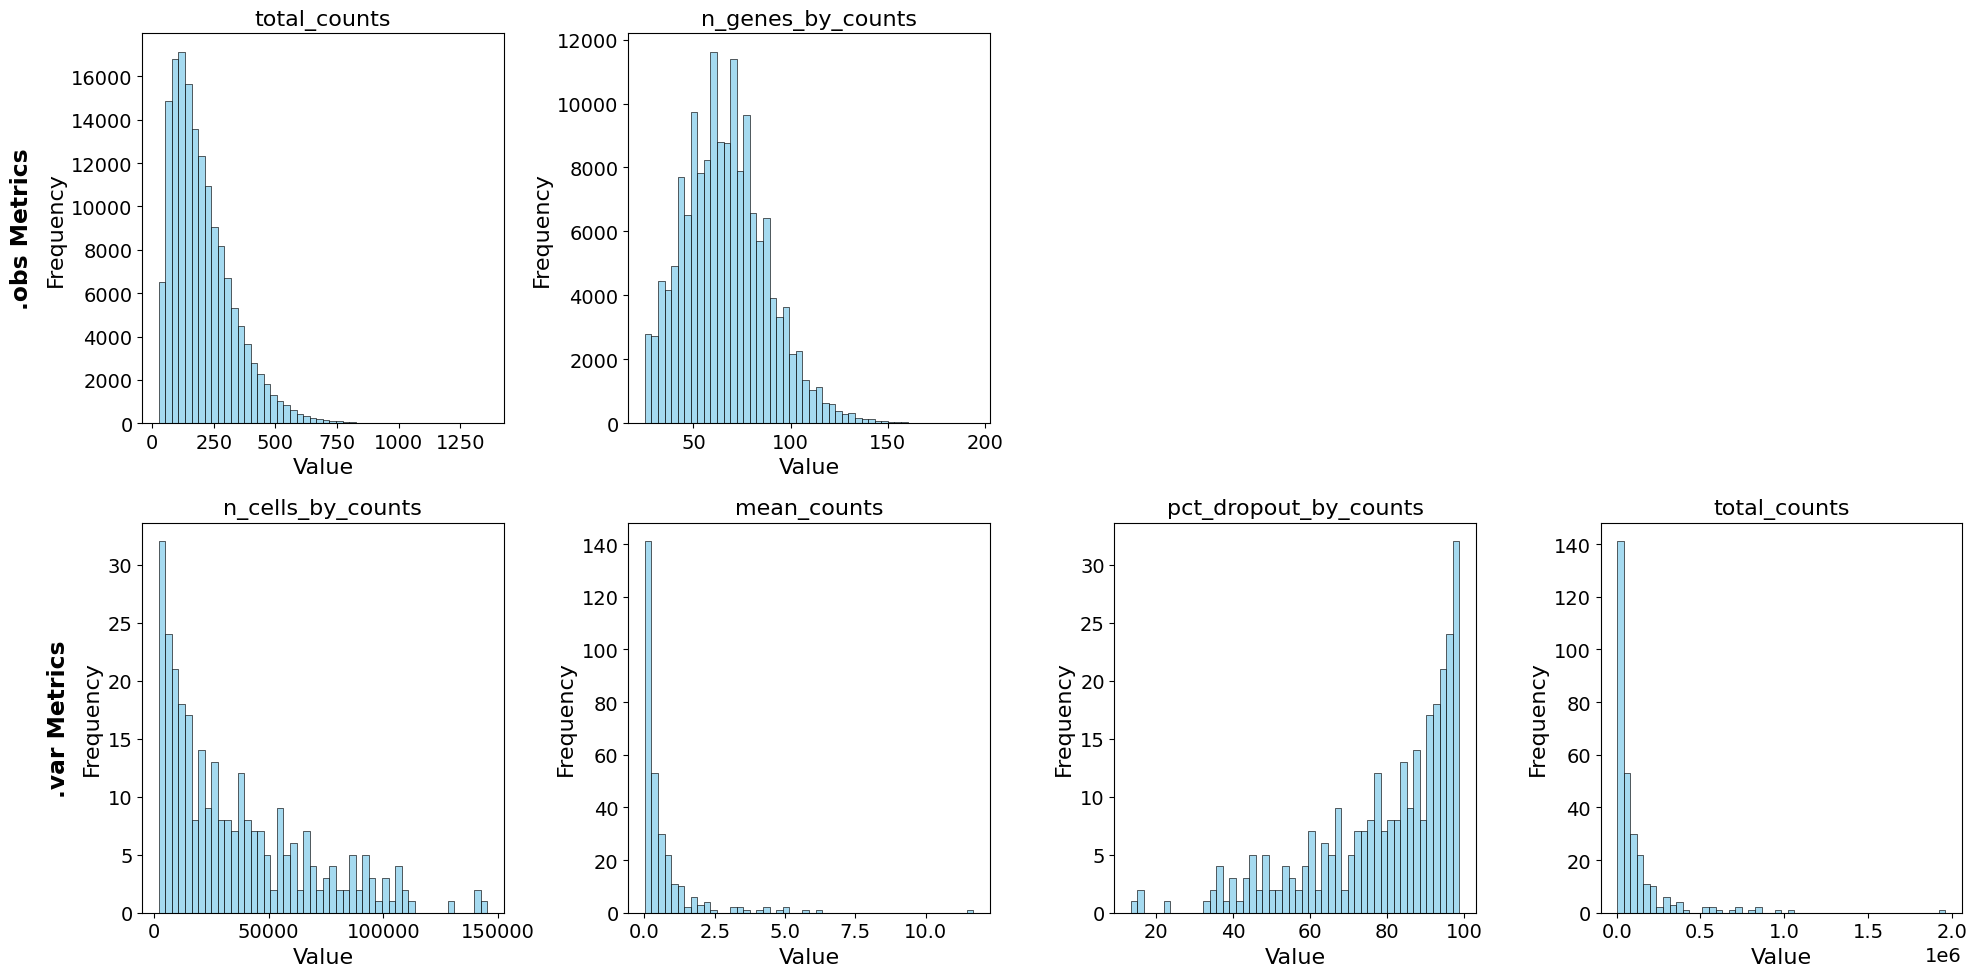

In [27]:
plot_qc_metrics(xd.cells.matrix)

Filtering of cells happens on the level of `.cells.matrix`. To synchronize the cells included in `.cells.matrix` and their boundaries in `.cells.boundaries` after the filtering, `.sync_cell_ids` can be called on `.cells`.

In [28]:
xd.cells.sync_cell_ids()

### Normalization and transformation

Two transformation methods were suggested for transforming in situ sequencing data: log-transformation and square root-transformation. To test which one is better suited for the current dataset, the `test_transformation` function can be used.

In [29]:
from insitupy.utils.preprocessing import test_transformation

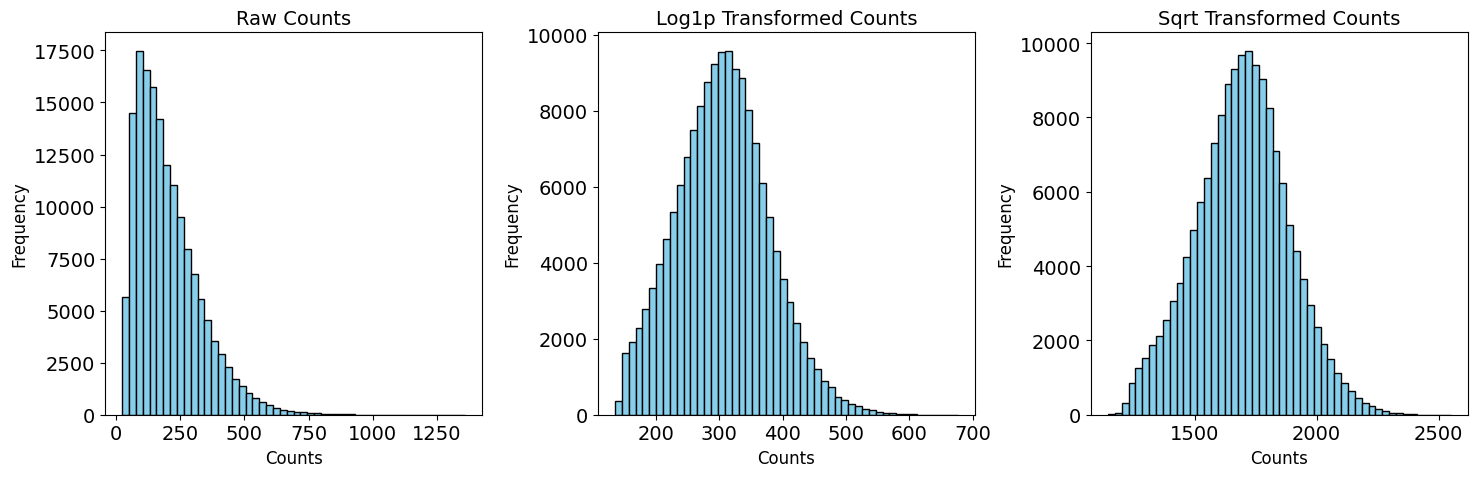

In [30]:
test_transformation(xd.cells.matrix)

Here, we decided to continue with the log-transformation, which is also the most common approach.

In [31]:
xd.normalize_and_transform(transformation_method="log1p")

Store raw counts in anndata.layers['counts']...
Normalization, log1p-transformation...


### Dimensionality reduction

Calculating the UMAP can take about 5-10 min due to the size of the dataset.

In [32]:
xd.reduce_dimensions(umap=True, tsne=False)

Dimensionality reduction...


c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Leiden clustering...


C:\Users\ge37voy\Github\InSituPy\insitupy\utils\preprocessing.py:213: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


### Show results using `scanpy` functions

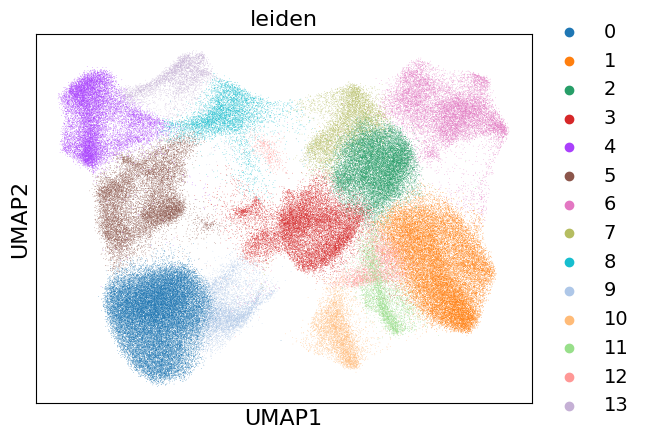

In [33]:
sc.pl.umap(xd.cells.matrix, color="leiden")

In [17]:
# visualize data
xd.show()

#### Start viewer with list of selected genes

Alternatively to selecting genes inside the napari viewer, it is also possible to open the viewer directly including a list of genes.

In [34]:
xd.show(keys=["leiden", "ACTA2", "LYZ", "LUM"])

Genes can be displayed or hidden via the eye symbol: <br>
<left><img src="./demo_screenshots/gene_selection.jpg" height="70"/></left>

## Save results within `InSituPy` project

The processed data can be saved into a folder using the `.saveas()` function of `InSituData`.

The resulting folder has following structure (can vary depending on which modalities have been loaded before):
```
insitupy_project_folder
│   .ispy
│
├───cells
│   └───uid
│       │   .celldata
│       │
│       ├───boundaries
│       │       cellular.zarr.zip
│       │       nuclear.zarr.zip
│       │
│       └───matrix
│               matrix.h5ad
│
├───images
│       morphology_mip.zarr.zip
│       slide_id__sample_id__CD20__registered.zarr.zip
│       slide_id__sample_id__HER2__registered.zarr.zip
│       slide_id__sample_id__HE__registered.zarr.zip
│
└───transcripts
        transcripts.parquet
```

In [35]:
xd.save()

Updating project in C:\Users\ge37voy\.cache\InSituPy\out\demo_insitupy_project
	Updating cells...
Saved.


In [36]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\.cache\InSituPy\out\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 157589 × 297
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'n_genes', 'leiden'
           var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
           uns: 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
           obsm: 'X_pca', 'X_umap', 'spatial'
           varm: 'PCs'
           layers: 'counts', 'norm_counts'
           obsp: 'connectivities', 'distances'
       boundaries
           BoundariesData object with 2 entries:
         

## Version history of data

It is also possible to keep a version history of the "variable" data in `InSituPy`. As variable data `InSituPy` considers `.cells`, `.annotations` and `.regions`. By default `keep_history=False`, but if you want to keep the history, it is also possible to set `keep_history=True` as in the following example. Importantly, if you want to keep the history, it is important to always set `keep_history=True`. Otherwise the history gets deleted the next time you just use `.save()`. This behavior is not really optimal and we will try to find a solution for that in the future.

In [ ]:
#xd.save(keep_history=True)